# Simple VAE example

In [1]:
import os 
import glob as glob
import random
import time

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Download F_mnist data set from: https://www.kaggle.com/zalando-research/fashionmnist

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values

X_train, X_valid = X_train/255, X_valid/255

In [4]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)

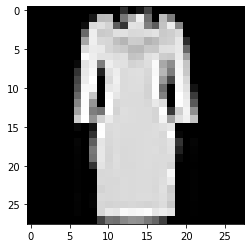

In [5]:
plt.imshow(X_train[4,:,:], cmap="gray")
plt.show()

## Custom Model with fit()
https://keras.io/guides/customizing_what_happens_in_fit/

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))    

In [7]:
class VAE(Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [8]:
codings_size = 20
n_pixels = 28*28

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.models.Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
    
# Declare decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
        
# Declare VAE
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)

vae = VAE(inputs=[inputs], outputs=[reconstructions])  

## Train model

In [9]:
latent_loss = -0.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean),
    axis=-1)

vae.add_loss(tf.math.reduce_mean(latent_loss) / n_pixels)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = vae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3889 - rounded_accuracy: 0.8635 - val_loss: 0.3474 - val_rounded_accuracy: 0.8974
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3423 - rounded_accuracy: 0.8991 - val_loss: 0.3358 - val_rounded_accuracy: 0.8981
Epoch 3/25
469/469 [==============================] - 3s 7ms/step - loss: 0.3317 - rounded_accuracy: 0.9070 - val_loss: 0.3263 - val_rounded_accuracy: 0.9103
Epoch 4/25
469/469 [==============================] - 3s 7ms/step - loss: 0.3266 - rounded_accuracy: 0.9105 - val_loss: 0.3238 - val_rounded_accuracy: 0.9142
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3233 - rounded_accuracy: 0.9132 - val_loss: 0.3204 - val_rounded_accuracy: 0.9136
Epoch 6/25
469/469 [

## Generate Sample

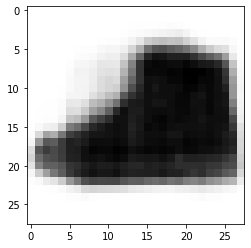

In [10]:
codings = tf.random.normal(shape=[1, codings_size])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:], cmap="binary")
plt.show()